# Business cycles across countries


In [41]:
import numpy as np
import eurostat
import matplotlib.pyplot as plt
import pandas as pd
import fredapi
import statsmodels.api as sm
from scipy import optimize

CB =  ['#000000','#004488','#BB5566','#DDAA33', 'purple']
LS = ['solid', 'dashed', ':', '-.']

def fkh(k,h,α,z=1):
    #Production function
    y = z*k**α*h**(1-α)
    return y

def wkh(k,h,α,z=1):
    #wage = MPL
    w = (1-α) *z* k**α*h**(-α)
    return w
    
def rkh(k,h,α,z=1):
    #r = MPK
    r = (α) * z*k**(α-1)*h**(1-α)
    return r
    
## Solve for the steady state values
def solve_ss(guess, α,σ,δ,β,φ,ρ,B,macurdy=1):
    k,c,h = guess
    
    diff1 = α*(k/h)**(α-1) - (1/β-1+δ) #Euler equation
    diff2 = c - fkh(k,h,α)+δ*k ##LOM for capital
    if macurdy==1:
        diff3 = wkh(k,h,α) - B*h**φ/(c**(-σ))
    else:
        diff3 = wkh(k,h,α) - B*h**φ
    

    return  np.array([(diff1),(diff2),(diff3)])


def solve_kh_back(guess, c_t, k_t1, α,σ,δ,φ,B, macurdy=1):
    k,h = guess

    diff1 = k_t1 + c_t - (1-δ)*k - fkh(k,h,α) ## Capital accumulation
    if macurdy ==1:
        diff2 = wkh(k,h,α) - B*h**φ/(c_t**(-σ))
    else :
        diff2 = wkh(k,h,α) - B*h**φ

    return  np.array([diff1,diff2])


def solvetrans(kvec_guess, zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss, h_ss,solve,macurdy=1):
    cvec = np.zeros(T,dtype= np.float64)
    cvec[T-1] = c_ss
    rvec = np.zeros(T,dtype= np.float64)
    rvec[T-1] = r_ss
    wvec = np.zeros(T,dtype= np.float64)
    wvec[T-1] = w_ss
    yvec = np.zeros(T,dtype= np.float64)
    yvec[T-1] = y_ss
    hvec = np.zeros(T,dtype= np.float64)
    hvec[T-1] = h_ss
    ivec = np.zeros(T,dtype= np.float64)
    ivec[T-1] = y_ss-c_ss
    mk = np.zeros(T,dtype= np.float64)

    kvec_guess[0] = k_ss
    kvec_guess[T-1] = k_ss
    ## Solve backwards: 
    for i in range(T-1,0,-1):
        #Consumption backwards from Euler equation
        k_t1 = kvec_guess[i]
        z_t1 = zvec[i]
        r_t1 = rkh(k_t1,hvec[i],α, z_t1)
        c_t1 = cvec[i]
        
        cvec[i-1] = ( β*(1-δ+r_t1)*c_t1**(-σ) )**(-1/σ)
        
        k_t = kvec_guess[i-1]
        c_t = cvec[i-1]
        z_t = zvec[i-1]
        
        ## solve for h using the intratemporal condition
        #Note: B*h_t**φ/c_t**(-σ) = z_t* (1-α)*k_t**α*h_t**α
        if macurdy ==1:
            hvec[i-1] = ( (c_t**(-σ) *  z_t* (1-α)*k_t**α )/B )**(1/(α+φ))
        else:
            hvec[i-1] = ( (             z_t* (1-α)*k_t**α )/B )**(1/(α+φ))

        h_t = hvec[i-1]
    
        rvec[i-1] = rkh(k_t,h_t,α,z_t)
        wvec[i-1] = wkh(k_t,h_t,α,z_t)
        yvec[i-1] = fkh(k_t,h_t,α,z_t)
        ivec[i-1] = yvec[i-1]-c_t
        
        ## market clearing
        mk[i-1] = k_t1 + c_t - (1 - δ)*k_t - yvec[i-1] 

    if solve ==1:
        return mk
    else :
        return hvec,cvec,rvec,wvec,yvec,ivec
        
def extractvalue(ss_vec,α):
    k_ss = ss_vec[0]
    c_ss = ss_vec[1]
    h_ss = ss_vec[2]
    r_ss = rkh(k_ss,h_ss,α)
    w_ss = wkh(k_ss,h_ss,α)
    y_ss = fkh(k_ss,h_ss,α)
    ky_ss = k_ss/y_ss
    print('Capital-output ratio: ',ky_ss)
    print('Hours: ',h_ss)
    print('Consumption: ',c_ss)
    return k_ss, c_ss, h_ss, r_ss, w_ss, y_ss, ky_ss
    
def plot_irf(outvec,kvec,zvec,s, xend):
    hvec,cvec,rvec,wvec,yvec,ivec = outvec
    plt.plot((np.log(yvec)-np.log(yvec[-1]))*100, label = 'Output', color = CB[1], linestyle = LS[1])
    plt.plot((np.log(cvec)-np.log(cvec[-1]))*100, label = 'Consumption', color = 'red' , linestyle = LS[0])
    plt.plot((np.log(ivec)-np.log(ivec[-1]))*100, label = 'Investment', color = CB[2], linestyle = LS[2])
    plt.plot((np.log(zvec)-np.log(zvec[-1]))*100, label = 'Productivity shock', color = CB[3], linestyle = LS[3])
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.ylim(-1,(np.log(yvec[0])-np.log(yvec[-1]))*100+1)
    plt.xlim(-1,xend)
    plt.xlabel('Quarters')
    plt.ylabel('Percent change')
    plt.legend()
    figname = 'bcirf1_'+str(s)+'.pdf'
    plt.savefig(figname)
    plt.show()
    
    plt.plot((np.log(hvec)-np.log(hvec[-1]))*100, label = 'Hours', color = CB[2], linestyle = LS[2])
    plt.plot((np.log(kvec)-np.log(kvec[-1]))*100, label = 'Capital', color = CB[3], linestyle = LS[3])
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.legend()
    plt.xlabel('Quarters')
    plt.ylabel('Percent change')
    plt.xlim(-1,xend)
    figname = 'bcirf2_'+str(s)+'.pdf'
    plt.savefig(figname)
    plt.show()
    
    plt.plot((np.log(wvec)-np.log(wvec[-1]))*100, label = 'Wages', color = CB[1], linestyle = LS[1])
    plt.plot((np.log(rvec)-np.log(rvec[-1]))*100, label = 'Interest rates', color = CB[0] , linestyle = LS[0])
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.xlabel('Quarters')
    plt.ylabel('Percent change')
    plt.legend()
    figname = 'bcirf3_'+str(s)+'.pdf'
    plt.savefig(figname)
    plt.xlim(-1,xend)
    plt.show()
   
    endvec = 50
    print(r'$\sigma_h/\sigma_y$: ', np.sqrt(np.var(np.log(hvec[0:endvec])))/np.sqrt(np.var(np.log(yvec[0:endvec]))))
    print(r'$\sigma_c/\sigma_y$: ',np.sqrt(np.var(np.log(cvec[0:endvec])))/np.sqrt(np.var(np.log(yvec[0:endvec]))))       
    print(r'$\sigma_i/\sigma_y$: ',np.sqrt(np.var(np.log(ivec[0:endvec])))/np.sqrt(np.var(np.log(yvec[0:endvec]))))   

C:\Users\qwp970\AppData\Local\anaconda3\lib\site-packages\scipy\optimize\_zeros_py.py:479: RuntimeWarning: some failed to converge after 1000 iterations
  warnings.warn(msg, RuntimeWarning)


Capital-output ratio:  4.293785321674311
Hours:  0.6298817292323535
Consumption:  1.165096016658573


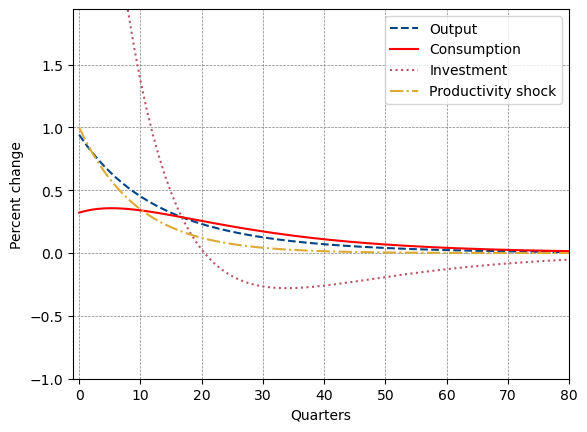

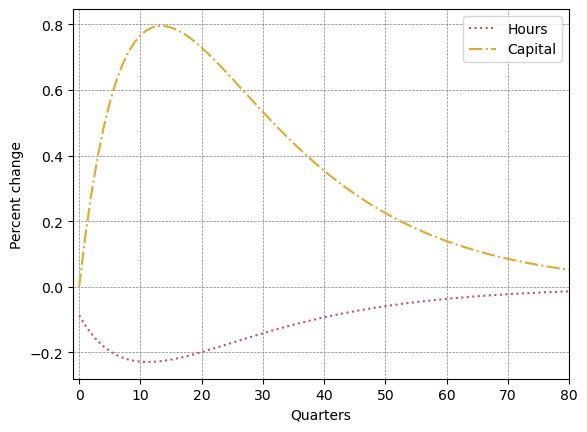

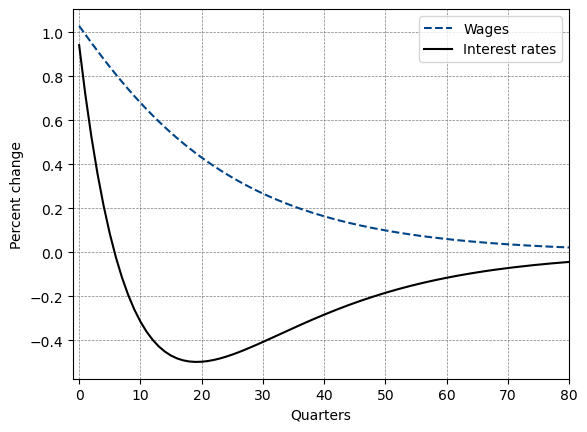

$\sigma_h/\sigma_y$:  0.22841756493214724
$\sigma_c/\sigma_y$:  0.4070757215647944
$\sigma_i/\sigma_y$:  6.501888112985886


In [42]:
## Parameters -- Calibration low volatility
α = 1/3
σ = 4 #2
δ = 0.025
β = 0.95
φ = 3 #3
ρ = 0.9
B = 3  
T = 150 #Length of IRF / time until we reach the steady state

## Solve for the steady state of the model
kguess = 5
cguess = 1
hguess = 0.7
guess = np.array([kguess,cguess,hguess])

ss_vec = optimize.newton(solve_ss,guess, args = (α,σ,δ,β,φ,ρ,B), tol=1e-10,maxiter = 1000)
k_ss, c_ss, h_ss, r_ss, w_ss, y_ss, ky_ss = extractvalue(ss_vec,α) 

## Solve for the IRF to a single productivity shock
lzvec = np.zeros(T,dtype= np.float64)
lzvec[0] = 0.01
for i in range(1,T):
    lzvec[i] = ρ*lzvec[i-1]
zvec = np.exp(lzvec)

kvec_guess = np.ones((T,1),dtype= np.float64)*k_ss
res = optimize.root(solvetrans,kvec_guess, args = (zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss, h_ss,1), tol=1e-10)
kvec1 = res.x
outvec1 = solvetrans(kvec1, zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss,h_ss,0)

## Simulate


plot_irf(outvec1,kvec1,zvec,σ,80)


Capital-output ratio:  4.29378272929993
Hours:  0.5314985952013148
Consumption:  0.9831181475324821


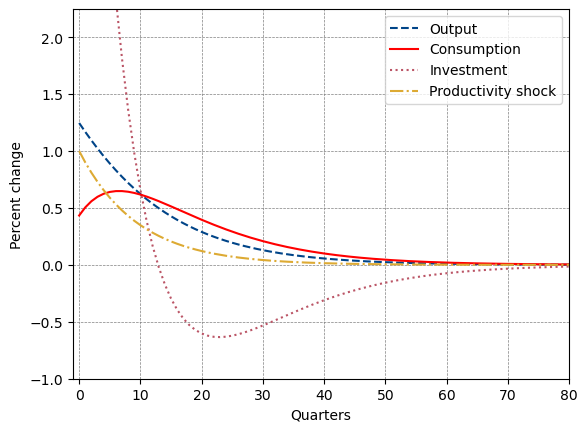

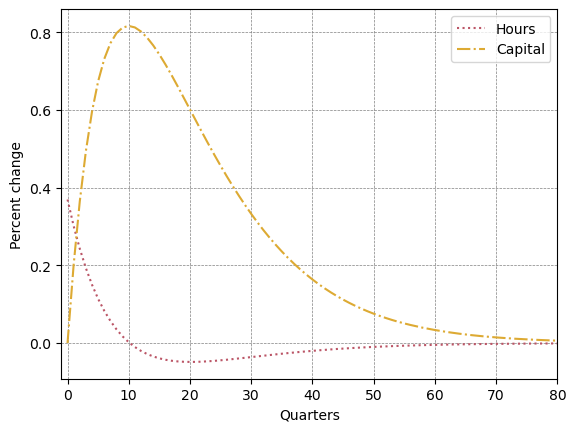

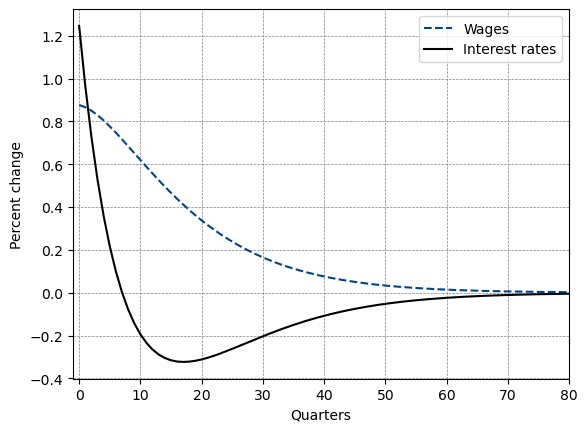

$\sigma_h/\sigma_y$:  0.2649179379035167
$\sigma_c/\sigma_y$:  0.6097892566702136
$\sigma_i/\sigma_y$:  5.590165910449761


In [43]:
## Parameters -- Calibration high volatility
α = 1/3
σ = 1.0001 #2
δ = 0.025
β = 0.95
φ = 1.2 #3
ρ = 0.9
B = 3  
T = 150 #Length of IRF / time until we reach the steady state

## Solve for the steady state of the model
kguess = 5
cguess = 1
hguess = 0.74
guess = np.array([kguess,cguess,hguess])

ss_vec = optimize.newton(solve_ss,guess, args = (α,σ,δ,β,φ,ρ,B), tol=1e-10,maxiter = 1000)
k_ss, c_ss, h_ss, r_ss, w_ss, y_ss, ky_ss = extractvalue(ss_vec,α) 

## Solve for the IRF to a single productivity shock
lzvec = np.zeros(T,dtype= np.float64)
lzvec[0] = 0.01
for i in range(1,T):
    lzvec[i] = ρ*lzvec[i-1]
zvec = np.exp(lzvec)

kvec_guess = np.ones((T,1),dtype= np.float64)*k_ss
res = optimize.root(solvetrans,kvec_guess, args = (zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss, h_ss,1), tol=1e-10)
kvec2 = res.x
outvec2 = solvetrans(kvec2, zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss,h_ss,0)

plot_irf(outvec2,kvec2,zvec,σ,80)


Capital-output ratio:  4.293785310386493
Hours:  0.6296854166587716
Consumption:  1.1647363213449569


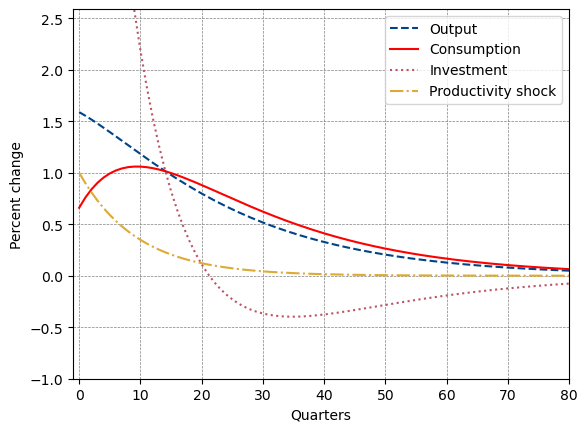

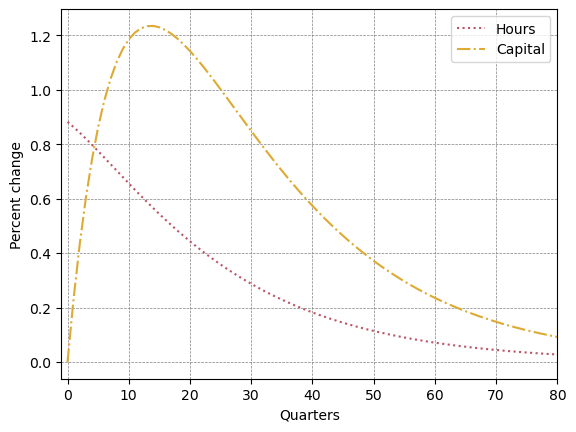

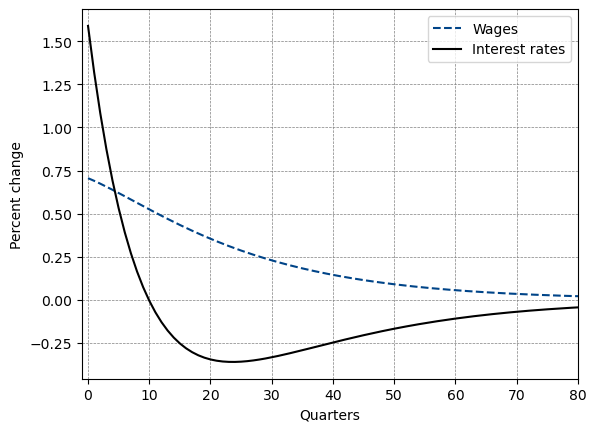

$\sigma_h/\sigma_y$:  0.5555555555555544
$\sigma_c/\sigma_y$:  0.6158568986416829
$\sigma_i/\sigma_y$:  5.663001331301397


In [50]:
## Parameters -- GHH preferences
α = 1/3
σ = 1.0001
δ = 0.025
β = 0.95
φ = 0.8 #3
ρ = 0.9
B = 2
T = 150 #Length of IRF / time until we reach the steady state

## Solve for the steady state of the model
kguess = 5
cguess = 1
hguess = 0.74
guess = np.array([kguess,cguess,hguess])

ss_vec = optimize.newton(solve_ss,guess, args = (α,σ,δ,β,φ,ρ,B,0), tol=1e-10,maxiter = 1000)
k_ss, c_ss, h_ss, r_ss, w_ss, y_ss, ky_ss = extractvalue(ss_vec,α) 

## Solve for the IRF to a single productivity shock
lzvec = np.zeros(T,dtype= np.float64)
lzvec[0] = 0.01
for i in range(1,T):
    lzvec[i] = ρ*lzvec[i-1]
zvec = np.exp(lzvec)

kvec_guess = np.ones((T,1),dtype= np.float64)*k_ss
res = optimize.root(solvetrans,kvec_guess, args = (zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss, h_ss,1,0), tol=1e-10)
kvec3 = res.x
outvec3 = solvetrans(kvec3, zvec, T,α,σ,δ,β,φ,ρ,B, c_ss, r_ss, w_ss, y_ss,k_ss,h_ss,0,0)

plot_irf(outvec3,kvec3,zvec,σ,80)


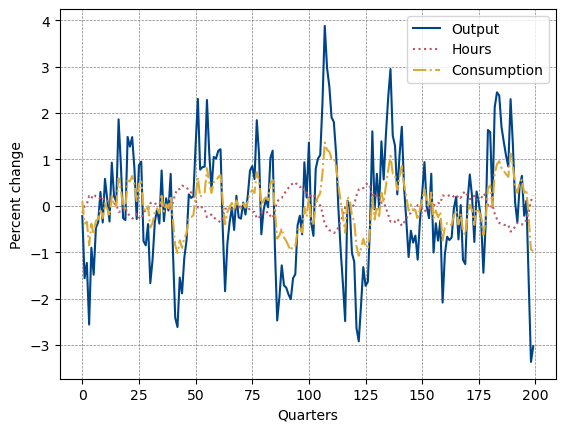

C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[0,0] = np.sqrt(np.var(cycle_y))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[1,0] = np.sqrt(np.var(cycle_c))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[2,0] = np.sqrt(np.var(cycle_i))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[3,0] = np.sqrt(np.var(cy

\begin{tabular}{lrrrr}
\toprule
 & $\sigma(x_t)$ & $\sigma(x_t)/\sigma(Y_t)$ & $\rho(x_t,x_{t-1})$ & $\rho(x_t,Y_t)$ \\
\midrule
$Y$ & 1.20 & 1.00 & 0.70 & 1.00 \\
$C$ & 0.45 & 0.38 & 0.77 & 0.94 \\
$I$ & 7.58 & 6.32 & 0.69 & 0.99 \\
$H$ & 0.20 & 0.17 & 0.91 & -0.63 \\
\bottomrule
\end{tabular}



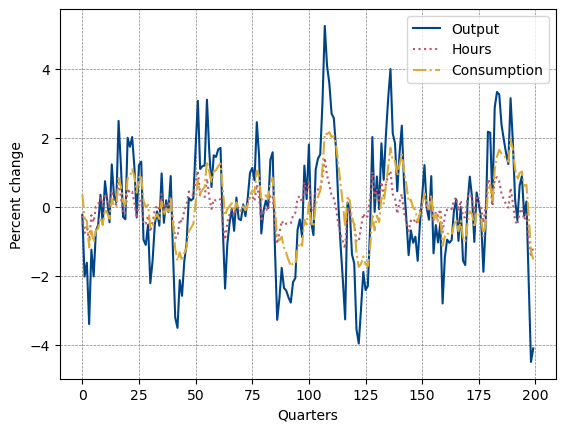

C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[0,0] = np.sqrt(np.var(cycle_y))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[1,0] = np.sqrt(np.var(cycle_c))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[2,0] = np.sqrt(np.var(cycle_i))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[3,0] = np.sqrt(np.var(cy

\begin{tabular}{lrrrr}
\toprule
 & $\sigma(x_t)$ & $\sigma(x_t)/\sigma(Y_t)$ & $\rho(x_t,x_{t-1})$ & $\rho(x_t,Y_t)$ \\
\midrule
$Y$ & 1.61 & 1.00 & 0.71 & 1.00 \\
$C$ & 0.76 & 0.47 & 0.86 & 0.86 \\
$I$ & 9.83 & 6.09 & 0.67 & 0.95 \\
$H$ & 0.47 & 0.29 & 0.67 & 0.93 \\
\bottomrule
\end{tabular}



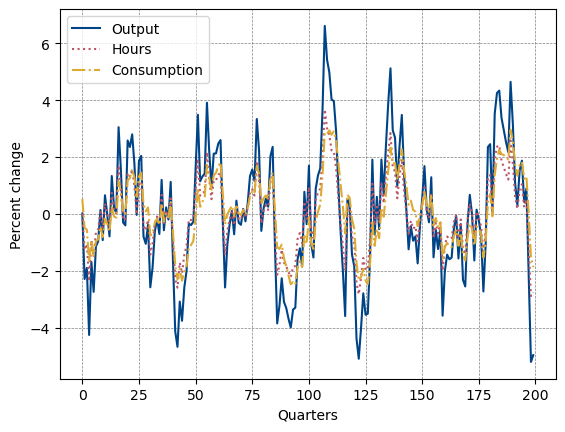

\begin{tabular}{lrrrr}
\toprule
 & $\sigma(x_t)$ & $\sigma(x_t)/\sigma(Y_t)$ & $\rho(x_t,x_{t-1})$ & $\rho(x_t,Y_t)$ \\
\midrule
$Y$ & 2.08 & 1.00 & 0.73 & 1.00 \\
$C$ & 1.09 & 0.52 & 0.84 & 0.91 \\
$I$ & 11.48 & 5.50 & 0.69 & 0.95 \\
$H$ & 1.16 & 0.56 & 0.73 & 1.00 \\
\bottomrule
\end{tabular}



C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[0,0] = np.sqrt(np.var(cycle_y))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[1,0] = np.sqrt(np.var(cycle_c))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:48: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[2,0] = np.sqrt(np.var(cycle_i))*100
C:\Users\qwp970\AppData\Local\Temp\ipykernel_22004\872684553.py:49: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  Tab[3,0] = np.sqrt(np.var(cy

In [51]:

## Simulate the model forwards
def bc_simulation(outvec,kvec,TT,figname):
    hvec,cvec,rvec,wvec,yvec,ivec = outvec

    np.random.seed(1234)
    zshockvec = np.random.normal(loc=0.0, scale=0.01, size=TT-T)
    eps = 0.01
    def simBKM(vec,TT,zshockvec,eps):
        bkmvec = (np.log(vec)-np.log(vec[-1]))/eps
        long_tl = np.zeros(TT)
        T = len(vec)
        for i in range(TT-T):
            long_tl[i:i+T] += bkmvec*zshockvec[i]
        return long_tl
    outvec_y = simBKM(yvec,TT,zshockvec,eps)
    outvec_h = simBKM(hvec,TT,zshockvec,eps)
    outvec_c = simBKM(cvec,TT,zshockvec,eps)
    outvec_i = simBKM(ivec,TT,zshockvec,eps)
    
    ## HP filter the series
    y_filtered,_ = sm.tsa.filters.hpfilter(outvec_y, lamb=1600)
    h_filtered,_ = sm.tsa.filters.hpfilter(outvec_h, lamb=1600)
    c_filtered,_ = sm.tsa.filters.hpfilter(outvec_c, lamb=1600)
    i_filtered,_ = sm.tsa.filters.hpfilter(outvec_i, lamb=1600)
    
    plt.plot(y_filtered[1000:1200]*100, color = CB[1], linestyle = LS[0], label = 'Output')
    plt.plot(h_filtered[1000:1200]*100, color = CB[2], linestyle = LS[2], label = 'Hours')
    plt.plot(c_filtered[1000:1200]*100, color = CB[3], linestyle = LS[3], label = 'Consumption')
    plt.grid(color = 'grey', linestyle = '--', linewidth = 0.5)
    plt.xlabel('Quarters')
    plt.ylabel('Percent change')
    plt.legend()
    plt.savefig(figname+'.pdf')
    plt.show()

    ## Business cycle moments
    cycle_y = pd.DataFrame(y_filtered)
    cycle_c = pd.DataFrame(c_filtered)
    cycle_i = pd.DataFrame(i_filtered)
    cycle_h = pd.DataFrame(h_filtered)
    #calculate autocorrelations
    ## Table
    Tab = np.zeros((4,4))
    
    ## Volatility
    Tab[0,0] = np.sqrt(np.var(cycle_y))*100
    Tab[1,0] = np.sqrt(np.var(cycle_c))*100
    Tab[2,0] = np.sqrt(np.var(cycle_i))*100
    Tab[3,0] = np.sqrt(np.var(cycle_h))*100
    ## Relative volatility
    Tab[0,1] = 1.0
    Tab[1,1] = np.sqrt(np.var(cycle_c))/np.sqrt(np.var(cycle_y))
    Tab[2,1] = np.sqrt(np.var(cycle_i))/np.sqrt(np.var(cycle_y))
    Tab[3,1] = np.sqrt(np.var(cycle_h))/np.sqrt(np.var(cycle_y))
    ## Autocorrelation
    Tab[0,2] = sm.tsa.acf(cycle_y)[1]
    Tab[1,2] = sm.tsa.acf(cycle_c)[1]
    Tab[2,2] = sm.tsa.acf(cycle_i)[1]
    Tab[3,2] = sm.tsa.acf(cycle_h)[1]
    ## Correlation with output
    alldata = pd.concat([cycle_y,cycle_c,cycle_i,cycle_h],axis =1)
    alldata.columns = ['y','c','i','h']
    corre = (alldata.corr())
    Tab[0,3] = corre['y']['y']
    Tab[1,3] = corre['y']['c']
    Tab[2,3] = corre['y']['i']
    Tab[3,3] = corre['y']['h']
    
    Table = pd.DataFrame(Tab)
    Table.index = [ r'$Y$', r'$C$', r'$I$', r'$H$']
    Table.columns = [ r'$\sigma(x_t)$', r'$\sigma(x_t)/\sigma(Y_t)$', r'$\rho(x_t,x_{t-1})$', r'$\rho(x_t,Y_t)$']
    print(Table.to_latex(float_format="%.2f"))
    
bc_simulation(outvec1,kvec1,10000,'bc_sim1') 
bc_simulation(outvec2,kvec2,10000,'bc_sim2')
bc_simulation(outvec3,kvec3,10000,'bc_sim3')
